In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch --branch main https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 226 (delta 102), reused 155 (delta 51), pack-reused 0
Receiving objects: 100% (226/226), 29.85 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (102/102), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./d

In [ ]:
import os
import numpy as np
import copy
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm, trange
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from tqdm.notebook import tqdm

# Напоминание практики

In [ ]:
class PixelNetwork(nn.Module):
    def __init__(self, input_shape, cf=64):
        super().__init__()
        self.input_shape = input_shape
        self.model = None
        
    
    def nll(self, x):
        raise NotImplementedError()

    def test(self, testloader):
        with torch.no_grad():
            loss = 0
            tc = 0
            for batch in testloader:
                loss = self.nll(batch.to(device).float()) * batch.shape[0]
                tc += batch.shape[0]
            return loss / tc
                

    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):

        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_data, batch_size=batch_size)

        train_loss = []
        test_loss = []

        optim = opt.Adam(self.parameters(), lr=lr)

        test_loss.append(self.test(testloader))

        for epoch in tqdm(range(num_epochs)):
            for batch in trainloader:
                loss = self.nll(batch.to(device).float())
                optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()

                train_loss.append(loss.cpu().data)
            test_loss_val = self.test(testloader)
            test_loss.append(test_loss_val)
            print(f'Epoch {epoch + 1}:', test_loss_val.item())
        return train_loss, test_loss

    def sample(self, n=100):
        raise NotImplementedError()

In [ ]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        # self.weight.data *= mask
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()

class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, :h // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1

In [ ]:
class PixelCNN(PixelNetwork):
    def __init__(self, input_shape, cf=64):
        super().__init__(input_shape, cf=64)
        self.input_shape = input_shape

        self.model = nn.Sequential(ConvA(1, cf, 7, 1, 3), nn.ReLU(), 
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(), 
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(),
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(),
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(),
                                   ConvB(cf, cf, 7, 1, 3), nn.ReLU(),
                                   ConvB(cf, cf, 1), nn.ReLU(), 
                                   ConvB(cf, 1, 1), nn.Sigmoid())
        
    
    def nll(self, x):
        return F.binary_cross_entropy(self.model(x), x)


    def sample(self, n=100):
        with torch.no_grad():
            samples = torch.zeros(n, 1, *self.input_shape).to(device)

            for i in range(self.input_shape[0]):
                for j in range(self.input_shape[1]):
                    probs = self.model(samples)[:, 0, i, j]
                    samples[:, 0, i, j] = torch.bernoulli(probs)
            return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)

In [ ]:
from dul_2021.utils.pr2_utils import *

def pr1(train_data, test_data, image_shape, dset_id):
    train_data = train_data.transpose(0, 3, 1, 2)
    test_data  = test_data.transpose(0, 3, 1, 2)
    model = PixelCNN(image_shape).to(device)
    tr_loss, te_loss = model.fit(train_data, test_data)
    samples = model.sample()
    return tr_loss, te_loss, samples

pr1_save_results(1, pr1)

# Question 1 PixelCNNs

In [ ]:
from dul_2021.utils.hw2_utils import *

## Part (a) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

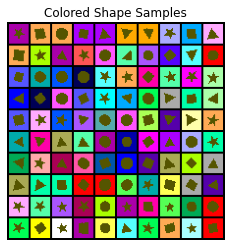

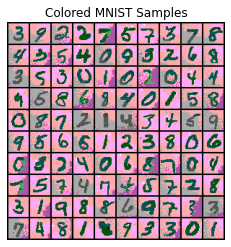

In [ ]:
visualize_q1a_data(1)
visualize_q1a_data(2)
# you can get access to the data with q1ab_get_data

In [ ]:
data = q1ab_get_data(1)
data.shape

(10479, 20, 20, 3)

In [ ]:
 data = q1ab_get_data(2)
 data.shape

(60000, 28, 28, 3)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, cf=120):
        super().__init__()

        self.block = nn.Sequential(
            nn.ReLU(), nn.Conv2d(in_ch, cf, 1),
            nn.ReLU(), ConvB(cf, cf, 7, 1, 3),
            nn.ReLU(), nn.Conv2d(cf, in_ch, 1),
        )
    def forward(self, x):
        out = self.block(x)
        out += x
        return out

In [ ]:
class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()

In [ ]:
def random_choice_prob_index(a, axis=1):
    r = np.expand_dims(np.random.rand(a.shape[1-axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

In [ ]:
class RGB1_PixelCNN(PixelNetwork):
    def __init__(self, input_shape, cf=120):
        super().__init__(input_shape, cf=64)
        self.input_shape = input_shape

        # color_num = 4
        # channel_num = 3

        layers = [nn.ReLU(), ConvA(3, cf, 7, 1, 3)]
        layers.extend([ResBlock(cf, cf), LayerNorm(cf)] * 4) ############################# 2
        layers.extend([nn.ReLU(), ConvB(cf, cf, 1),
                       nn.ReLU(), ConvB(cf, 4 * 3, 1)])
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        bs = x.shape[0]
        out = (x.float() / (4 - 1) - 0.5) / 0.5
        out = self.model(x)
        out = out.view(bs, 4, *self.input_shape)
        return out

    def nll(self, x):
        return F.cross_entropy(self(x), x.long())


    def sample(self, n=100):
        # input_shape = [3, 20, 20]
        with torch.no_grad():
            samples = torch.zeros(n, *self.input_shape).to(device)

            for i in range(self.input_shape[1]):
                for j in range(self.input_shape[2]):
                    probs = self(samples).softmax(1).cpu().detach().numpy()
                    for c in range(3):
                        ch_sample = random_choice_prob_index(probs[:, :, c, i, j], 1)
                        ch_sample = torch.Tensor(ch_sample).to(device)
                        samples[:, c, i, j] = ch_sample
                
            return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)

In [ ]:
def q1_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets
            
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    image_shape = (3, 28, 28)
    train_data = train_data.transpose(0, 3, 1, 2)
    test_data  = test_data.transpose(0, 3, 1, 2)
    model = RGB1_PixelCNN(image_shape).to(device)
    tr_loss, te_loss = model.fit(train_data, test_data, num_epochs=15)
    samples = model.sample()
    return tr_loss, te_loss, samples



### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.0005859694210812449
Epoch 2: 0.00046688405564054847
Epoch 3: 0.0002541706489864737
Epoch 4: 0.00023661127488594502
Epoch 5: 0.00022749693016521633
Epoch 6: 0.00020055474305991083
Epoch 7: 0.00020247677457518876
Epoch 8: 0.0016096386825665832
Epoch 9: 0.0003714259364642203
Epoch 10: 0.00022479274775832891
Epoch 11: 0.00020709015370812267
Epoch 12: 0.00020702028996311128
Epoch 13: 0.00019415424321778119
Epoch 14: 0.00019508413970470428
Epoch 15: 0.0001907366531668231
Epoch 16: 0.00018900759459938854
Epoch 17: 0.00018256685871165246
Epoch 18: 0.0001808990491554141
Epoch 19: 0.00017637918062973768
Epoch 20: 0.00017764043877832592
Final Test Loss: 0.0002


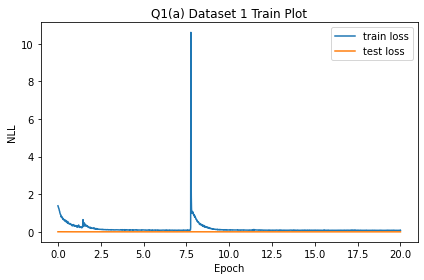

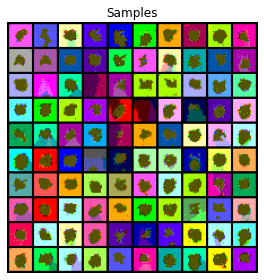

In [ ]:
q1ab_save_results(1, 'a', q1_a)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.0006961629260331392
Epoch 2: 0.0002611596428323537
Epoch 3: 0.00020141986897215247
Epoch 4: 0.0001866779784904793
Epoch 5: 0.0001749325165292248
Epoch 6: 0.00017427671991754323
Epoch 7: 0.00016563957615289837
Epoch 8: 0.00015991814143490046
Epoch 9: 0.00015697292110417038
Epoch 10: 0.00015430065104737878
Epoch 11: 0.0008529642946086824
Epoch 12: 0.0003450255608186126
Epoch 13: 0.00019445994985289872
Epoch 14: 0.00017695498536340892
Epoch 15: 0.00016983604291453958
Epoch 16: 0.00016516937466803938
Epoch 17: 0.00016315124230459332
Epoch 18: 0.00015870342031121254
Epoch 19: 0.00015244769747368991
Epoch 20: 0.00014975661179050803
Final Test Loss: 0.0001


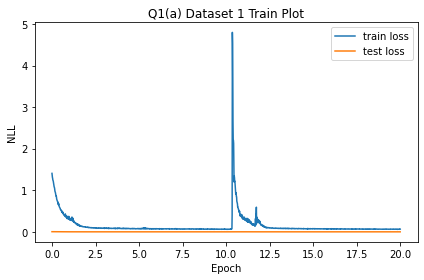

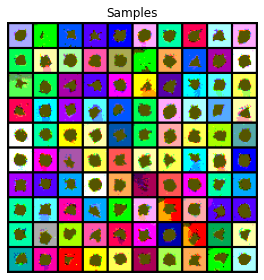

In [ ]:
q1ab_save_results(1, 'a', q1_a) # c layer norm

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.0007465182570740581
Epoch 2: 0.00030069571221247315
Epoch 3: 0.00021058243873994797
Epoch 4: 0.00018589345563668758
Epoch 5: 0.00017552674398757517
Epoch 6: 0.00017184350872412324
Epoch 7: 0.0001584668643772602
Epoch 8: 0.00015256446204148233
Epoch 9: 0.00015631495625711977
Epoch 10: 0.00014316833403427154
Epoch 11: 0.00014471804024651647
Epoch 12: 0.00014137307880446315
Epoch 13: 0.00013472283899318427
Epoch 14: 0.00014284120697993785
Epoch 15: 0.00014098407700657845
Epoch 16: 0.00012948873336426914
Epoch 17: 0.00013189746823627502
Epoch 18: 0.00012657787010539323
Epoch 19: 0.00012378675455693156
Epoch 20: 0.00012237753253430128
Final Test Loss: 0.0001


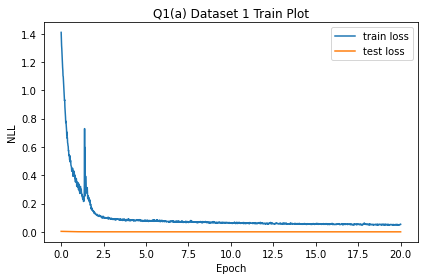

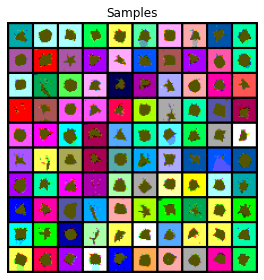

In [ ]:
q1ab_save_results(1, 'a', q1_a) # c layer norm + нормализацией входа в (-1, 1)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.0007196610677056015
Epoch 2: 0.0002584311587270349
Epoch 3: 0.0002023201232077554
Epoch 4: 0.00018885803001467139
Epoch 5: 0.00019733088265638798
Epoch 6: 0.00017638177087064832
Epoch 7: 0.00016267868340946734
Epoch 8: 0.00016180305101443082
Epoch 9: 0.0005671547842212021
Epoch 10: 0.00020250013039913028
Epoch 11: 0.00018467431073077023
Epoch 12: 0.00016648364544380456
Epoch 13: 0.00016504473751410842
Epoch 14: 0.0001581863616593182
Epoch 15: 0.0001549105509184301
Epoch 16: 0.00015787637676112354
Epoch 17: 0.0001574017951497808
Epoch 18: 0.0001467945839976892
Epoch 19: 0.0001452821888960898
Epoch 20: 0.0001459710911149159
Final Test Loss: 0.0001


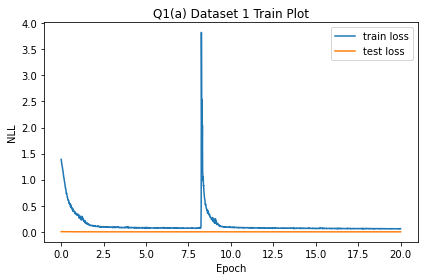

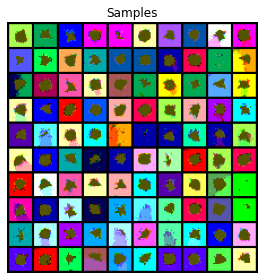

In [ ]:
q1ab_save_results(1, 'a', q1_a) # c layer norm + нормализацией входа в (-1, 1) + grad_clip

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.0006590817356482148
Epoch 2: 0.0004144338017795235
Epoch 3: 0.00022242717386689037
Epoch 4: 0.00018843729048967361
Epoch 5: 0.0001769532827893272
Epoch 6: 0.0001656722743064165
Epoch 7: 0.0001604559802217409
Epoch 8: 0.00015417706163134426
Epoch 9: 0.00014524167636409402
Epoch 10: 0.00017067611042875797
Epoch 11: 0.00014014390762895346
Epoch 12: 0.00013281454448588192
Epoch 13: 0.000129829699289985
Epoch 14: 0.0001272785011678934
Epoch 15: 0.00012680575309786946
Epoch 16: 0.00012093703116988763
Epoch 17: 0.00011990483471890911
Epoch 18: 0.0001165656722150743
Epoch 19: 0.00011498457752168179
Epoch 20: 0.0001120426386478357
Final Test Loss: 0.0001


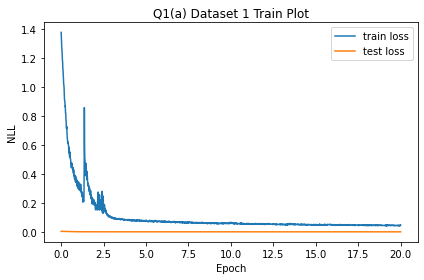

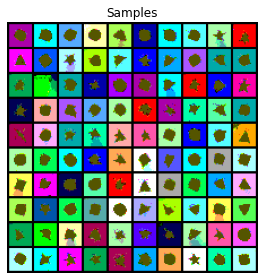

In [ ]:
q1ab_save_results(1, 'a', q1_a) # c layer norm + нормализацией входа в (-1, 1) + 8 блоков + no grad_clip

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.0006128724198788404
Epoch 2: 0.0003482224128674716
Epoch 3: 0.00021934071264695376
Epoch 4: 0.00018221659411210567
Epoch 5: 0.00015934598923195153
Epoch 6: 0.00015167247329372913
Epoch 7: 0.0002480357070453465
Epoch 8: 0.00014166753680910915
Epoch 9: 0.00013525081158149987
Epoch 10: 0.0001294002286158502
Epoch 11: 0.00015047102351672947
Epoch 12: 0.00012630142737179995
Epoch 13: 0.00011898115917574614
Epoch 14: 0.00011719057511072606
Epoch 15: 0.00012008475459879264
Epoch 16: 0.00011128401092719287
Epoch 17: 0.00010588100121822208
Epoch 18: 0.00010650804324541241
Epoch 19: 0.00010560105147305876
Epoch 20: 0.00010401829786133021
Final Test Loss: 0.0001


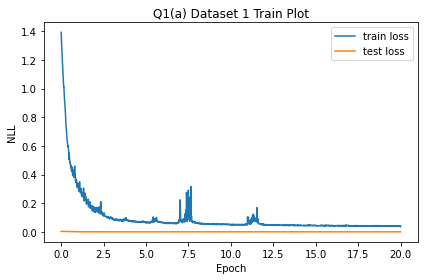

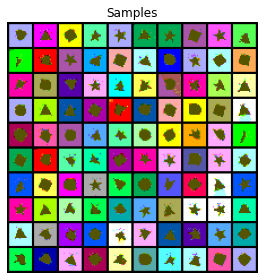

In [ ]:
q1ab_save_results(1, 'a', q1_a) # c layer norm + нормализацией входа в (-1, 1) + 8 блоков + grad_clip

Final Test Loss: 0.0444


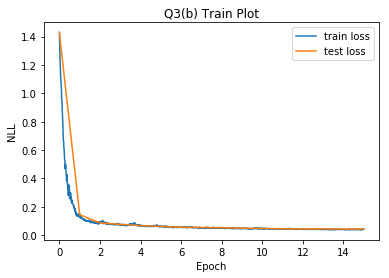

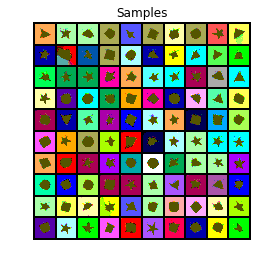

In [ ]:
q1ab_save_results(1, 'a', q1_a) # ref

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: 0.0003213164454791695
Epoch 2: 0.0002051342453341931
Final Test Loss: 0.0002


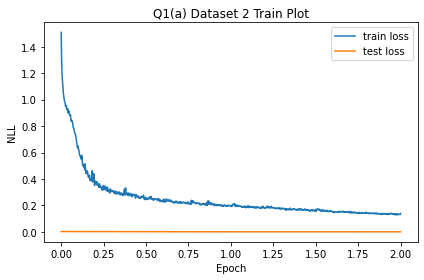

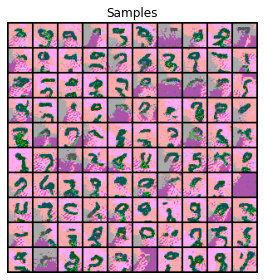

In [ ]:
q1ab_save_results(2, 'a', q1_a) # c layer norm + нормализацией входа в (-1, 1) + 8 блоков + grad_clip -- 2 эпохи

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: 0.0003242809616494924
Epoch 2: 0.00024271695292554796
Epoch 3: 0.00018710042058955878
Epoch 4: 0.00016493331349920481
Epoch 5: 0.000158780807396397
Epoch 6: 0.00015500554582104087
Epoch 7: 0.00015092582907527685
Epoch 8: 0.00015129598614294082
Epoch 9: 0.00015370544861070812
Epoch 10: 0.0001481184153817594
Epoch 11: 0.00014772107533644885
Epoch 12: 0.00014378366176970303
Epoch 13: 0.0001442762732040137
Epoch 14: 0.00013992408639751375
Epoch 15: 0.00013911047426518053
Final Test Loss: 0.0001


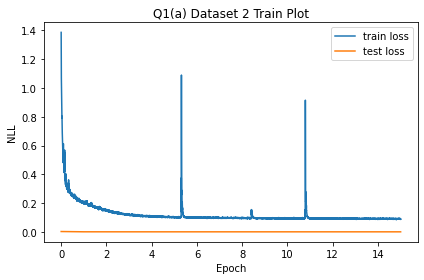

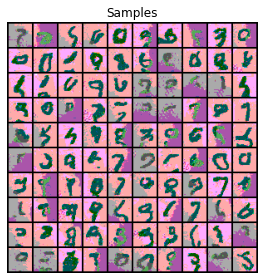

In [ ]:
q1ab_save_results(2, 'a', q1_a) # c layer norm + нормализацией входа в (-1, 1) + 4 блока + grad_clip -- 15 эпох

## Part (b) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        # self.weight.data *= mask
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()

class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        in_ch = self.in_channels
        out_ch = self.out_channels
        self.mask[:, :, h // 2, :w // 2] = 1
        self.mask[:, :, :h // 2] = 1

        # разбираемся с зависимостью каналов
        self.mask[out_ch // 3: 2 * (out_ch // 3), : in_ch // 3, h // 2, w // 2] = 1
        self.mask[2 * (out_ch //3):, : 2 * (in_ch // 3), h // 2, w // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):

        h, w = self.kernel_size
        in_ch = self.in_channels
        out_ch = self.out_channels
        self.mask[:, :, :h // 2] = 1
        self.mask[:, :, h // 2, :w // 2] = 1

        # разбираемся с зависимостью каналов
        self.mask[:out_ch // 3, :in_ch // 3, h // 2, w // 2] = 1
        self.mask[out_ch // 3: 2 * (out_ch // 3), : 2 * (in_ch // 3), h // 2, w // 2] = 1
        self.mask[2 * (out_ch // 3):, :, h // 2, w // 2] = 1


In [ ]:
class RGB2_PixelCNN(PixelNetwork):
    def __init__(self, input_shape, cf=120):
        super().__init__(input_shape, cf=64)
        self.input_shape = input_shape

        # color_num = 4
        # channel_num = 3

        layers = [nn.ReLU(), ConvA(3, cf, 7, 1, 3)]
        # layers.extend([ResBlock(cf, cf), LayerNorm(cf)] * 2) ############################# 8
        layers.extend([ResBlock(cf, cf)] * 8) ############################# 8
        layers.extend([nn.ReLU(), ConvB(cf, cf, 1),
                       nn.ReLU(), ConvB(cf, 4 * 3, 1)])
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        bs = x.shape[0]
        out = (x.float() / (4 - 1) - 0.5) / 0.5
        out = self.model(x)
        out = out.view(bs, 4, *self.input_shape)
        # out = out.view(bs, 3, 4, *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
        return out

    def nll(self, x):
        return F.cross_entropy(self(x), x.long())


    def sample(self, n=100):
        # input_shape = [3, 20, 20]
        with torch.no_grad():
            samples = torch.zeros(n, *self.input_shape).to(device)

            for i in range(self.input_shape[1]):
                for j in range(self.input_shape[2]):
                    probs = self(samples).softmax(1).cpu().detach().numpy()
                    for c in range(3):
                        ch_sample = random_choice_prob_index(probs[:, :, c, i, j], 1)
                        ch_sample = torch.Tensor(ch_sample).to(device)
                        samples[:, c, i, j] = ch_sample
                
            return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)

In [ ]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
  
    image_shape = (3, 20, 20)
    train_data = train_data.transpose(0, 3, 1, 2)
    test_data  = test_data.transpose(0, 3, 1, 2)
    model = RGB2_PixelCNN(image_shape).to(device)
    tr_loss, te_loss = model.fit(train_data, test_data, num_epochs=20)
    samples = model.sample()
    return tr_loss, te_loss, samples

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: 0.0008631673408672214
Epoch 2: 0.0005037506925873458
Final Test Loss: 0.0005


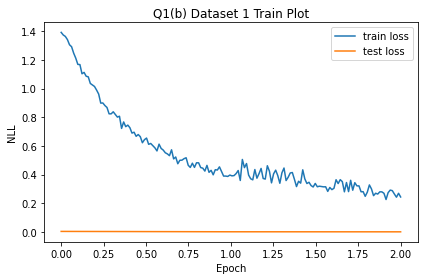

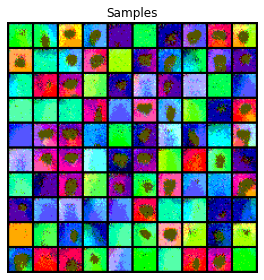

In [ ]:
q1ab_save_results(1, 'b', q1_b) # 2 блока, нормир вход, grad_clip

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.0008544852025806904
Epoch 2: 0.0006387708126567304
Epoch 3: 0.000362380436854437
Epoch 4: 0.00028788275085389614
Epoch 5: 8.211343083530664e-05
Epoch 6: 7.688776531722397e-05
Epoch 7: 2.3462116587325e-05
Epoch 8: 3.2458453915751306e-06
Epoch 9: 2.8933709472767077e-06
Epoch 10: 2.7254245651420206e-06
Epoch 11: 2.6125978820346063e-06
Epoch 12: 2.5898048079397995e-06
Epoch 13: 2.527425976950326e-06
Epoch 14: 2.486915036570281e-06
Epoch 15: 2.5876106519717723e-06
Epoch 16: 2.6059994979732437e-06
Epoch 17: 2.759886456260574e-06
Epoch 18: 2.630282097015879e-06
Epoch 19: 2.5812009880610276e-06
Epoch 20: 3.462687163846567e-05
Final Test Loss: 0.0000


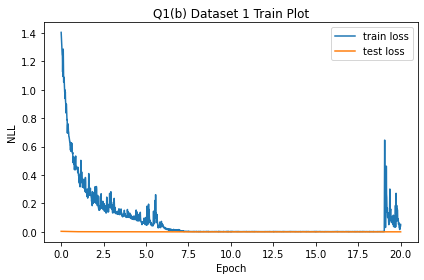

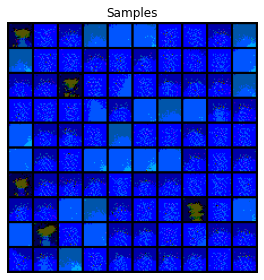

In [ ]:
q1ab_save_results(1, 'b', q1_b) # 8 блоков, нормир вход, grad_clip

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.0009232813026756048
Epoch 2: 0.0005627595819532871
Epoch 3: 0.00042779368232004344
Epoch 4: 0.00030600675381720066
Epoch 5: 0.00021667356486432254
Epoch 6: 9.682249947218224e-05
Epoch 7: 4.9589420086704195e-05
Epoch 8: 8.363081724382937e-05
Epoch 9: 8.774679372436367e-06
Epoch 10: 3.6912899759045104e-06
Epoch 11: 3.15269880957203e-06
Epoch 12: 3.0206815608835313e-06
Epoch 13: 2.7659923489409266e-06
Epoch 14: 2.7220730771659873e-06
Epoch 15: 2.6401517061458435e-06
Epoch 16: 2.7251153369434178e-06
Epoch 17: 2.6840730242838617e-06
Epoch 18: 3.1070112527231686e-06
Epoch 19: 2.6440782221470727e-06
Epoch 20: 2.8220570129633415e-06
Final Test Loss: 0.0000


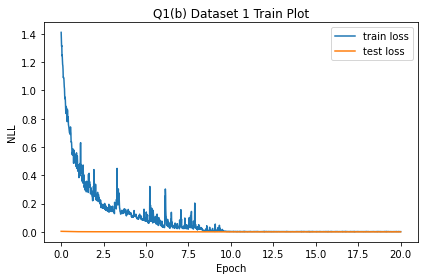

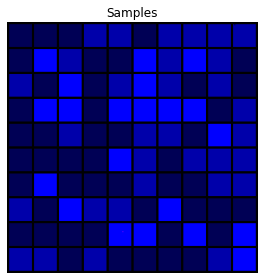

In [ ]:
q1ab_save_results(1, 'b', q1_b) # 8 блоков, нормир вход, grad_clip -- изменил view в forward

Final Test Loss: 0.0236


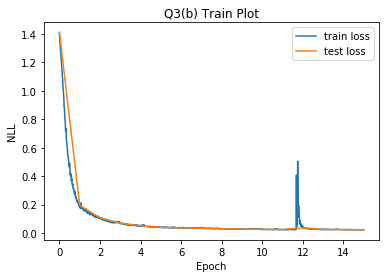

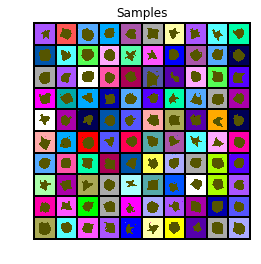

In [ ]:
q1ab_save_results(1, 'b', q1_b) # ref

## Part (c) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskedConv(nn.Conv2d):
    def __init__(self, classes_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.V = nn.Linear(classes_num, self.weight.shape[0])
        self.set_mask()
    
    def forward(self, x, y):
        # self.weight.data *= mask
        out = F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)
        out += self.V(y)[:, :, None, None]
        return out

    def set_mask(self):
        raise NotImplementedError()

class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, :h // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1

In [ ]:
class fake_ReLU(nn.ReLU):
  def __init__(self, *args, **kwargs):
    super().__init__()

  def forward(self, x, y):
    x = super().forward(x)
    return x

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, classes_num, in_ch, cf=120):
        super().__init__()

        self.block = nn.Sequential(
            fake_ReLU(), ConvB(classes_num=classes_num, in_channels=in_ch, out_channels=cf, kernel_size=1),
            fake_ReLU(), ConvB(classes_num=classes_num, in_channels=cf, out_channels=cf, kernel_size=7, stride=1, padding=3),
            fake_ReLU(), ConvB(classes_num=classes_num, in_channels=cf, out_channels=in_ch, kernel_size=1),
        )
    def forward(self, x, y):
        out = x
        for i in range(len(self.block)):
            out = self.block[i](out, y)
        out += x
        return out

In [ ]:
from torch.utils.data import Dataset

class CondDataset(Dataset):
  def __init__(self, x, y):
    super().__init__()
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [ ]:
class COND_PixelCNN(PixelNetwork):
    def __init__(self, classes_num, input_shape, cf=120):
        super().__init__(input_shape, cf=120)
        self.input_shape = input_shape
        self.classes_num = classes_num
        in_ch = 1
        # colors_num = 2
        layers = [ConvA(classes_num, in_ch, cf, 7, 1, 3), fake_ReLU()]
        # layers.extend([ResBlock(classes_num, cf, cf), LayerNorm(cf)] * 2)
        layers.extend([ResBlock(classes_num, cf, cf)] * 2)
        layers.extend([fake_ReLU(), ConvB(classes_num, cf, cf, 1),
                       fake_ReLU(), ConvB(classes_num, cf, in_ch * 2, 1)])
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, y):
        # y - one hot torch tensor
        bs = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        y = F.one_hot(y, self.classes_num).float()
        for i in range(len(self.model)):
            out = self.model[i](out, y)
        out = out.view(bs, 1, 2, *self.input_shape[1:])
        return out.permute(0, 2, 1, 3, 4)

    def nll(self, x):
        X, y = x
        X = X.to(device).float()
        y = y.to(device)
        # y = F.one_hot(y, self.classes_num).to(device).float()
        return F.cross_entropy(self(X, y), X.long())

    def test(self, testloader):
        with torch.no_grad():
            loss = 0
            tc = 0
            for batch in testloader:
                loss += self.nll(batch) * batch[0].shape[0]
                tc += batch[0].shape[0]
        return loss / tc
                

    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):

        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_data, batch_size=batch_size)

        train_loss = []
        test_loss = []

        optim = opt.Adam(self.parameters(), lr=lr)

        test_loss.append(self.test(testloader))

        for epoch in tqdm(range(num_epochs)):
            for batch in trainloader:
                loss = self.nll(batch)
                optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()

                train_loss.append(loss.cpu().data)
            test_loss_val = self.test(testloader)
            test_loss.append(test_loss_val)
            print(f'Epoch {epoch + 1}:', test_loss_val.item())
        return train_loss, test_loss


    def sample(self, classes, n=100):
        # input_shape = [3, 20, 20]
        self.eval()
        with torch.no_grad():
            samples = torch.zeros(n, *self.input_shape).to(device)

            for i in range(self.input_shape[1]):
                for j in range(self.input_shape[2]):
                    for c in range(1):
                        probs = self(samples, classes).softmax(1)
                        probs = probs[:, :, c, i, j]
                        ch_sample = torch.multinomial(probs, 1).squeeze(-1)   
                        samples[:, c, i, j] = ch_sample
                
            return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)

In [ ]:
def q1_c(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
    """
    train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
    train_labels: A (n_train,) numpy array of class labels
    test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
    test_labels: A (n_test,) numpy array of class labels
    image_shape: (H, W), height and width
    n_classes: number of classes (4 or 10)
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
      where an even number of images of each class are sampled with 100 total
    """
  
    

    train_data_img = train_data.transpose(0, 3, 1, 2)
    test_data_img  = test_data.transpose(0, 3, 1, 2)

    H, W = train_data_img.shape[2:]
    image_shape = (1, H, W)

    
    train_data_labels = train_labels
    test_data_labels  = test_labels

    classes_num = len(np.unique(np.concatenate([train_data_labels, test_data_labels])))


    train_dataset = CondDataset(torch.Tensor(train_data_img), torch.LongTensor(train_data_labels))
    test_dataset = CondDataset(torch.Tensor(test_data_img), torch.LongTensor(test_data_labels))

    model = COND_PixelCNN(classes_num, image_shape).to(device)
    tr_loss, te_loss = model.fit(train_dataset, test_dataset, num_epochs=10)


    classes = torch.tensor(np.repeat(np.arange(classes_num), 100 // classes_num)).to(device)
    samples = model.sample(classes)
    return tr_loss, te_loss, samples

### Results

Once you've implemented `q1_c`, execute the cells below to visualize and save your results



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: 0.07946982234716415
Epoch 2: 0.0659220740199089
Epoch 3: 0.057174067944288254
Epoch 4: 0.04832000285387039
Epoch 5: 0.045441046357154846
Epoch 6: 0.04433364421129227
Epoch 7: 0.042298994958400726
Epoch 8: 0.046619366854429245
Epoch 9: 0.04016624763607979
Epoch 10: 0.04123535379767418
Final Test Loss: 0.0412


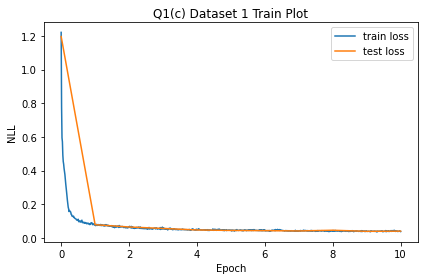

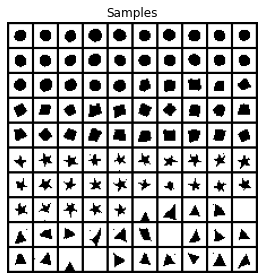

In [ ]:
q1c_save_results(1, q1_c)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: 0.0834081843495369
Epoch 2: 0.08182729780673981
Epoch 3: 0.07902071624994278
Epoch 4: 0.07734924554824829
Epoch 5: 0.07695970684289932
Epoch 6: 0.07603003084659576
Epoch 7: 0.07572102546691895
Epoch 8: 0.07617420703172684
Epoch 9: 0.0752440020442009
Epoch 10: 0.07579472661018372
Final Test Loss: 0.0758


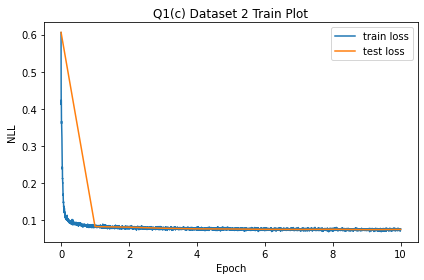

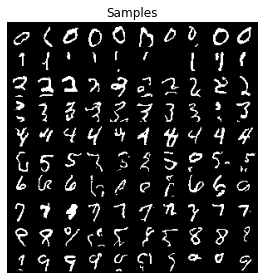

In [ ]:
q1c_save_results(2, q1_c)

# Bonus 1: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
#b1ab_get_data()

In [ ]:
def b1_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_a`, execute the cells below to visualize and save your results



In [ ]:
b1a_save_results(b1_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b1_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_b`, execute the cells below to visualize and save your results



In [ ]:
q1b_save_results(q1_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
#b1c_get_data()

In [ ]:
def b1_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_c`, execute the cells below to visualize and save your results



In [ ]:
b1c_save_results(b1_c)